# Generate training data

256×169 samples</p>
### Change demand
timestep = 1h, 1 week ->169 timesteps in total</p>
at every timestep, change the nodal demand</p>
### Change topology
Randomly cut the connectivity between two pipes, but preserving the connectivity between each node in the network and source. ->256 topology

### Try single timestep

In [62]:
import wntr
import networkx as nx
import scipy.sparse as sp
import numpy as np 
import random
import tqdm
import os 
import matplotlib.pyplot as plt
import itertools
from collections import Counter 
import networkx as nx
import copy
import pandas as pd
import tensorflow_gnn as tfgnn
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
# To use standard datasets that fit in memory.
from tensorflow_gnn.experimental.in_memory import datasets

# Implementations of example GNN models.
from tensorflow_gnn.experimental.in_memory import models

# Converts `tfgnn.GraphTensor` to (`tfgnn.GraphTensor`, `tf.Tensor`)
# with second item containing task labels.
from tensorflow_gnn.experimental.in_memory import reader_utils

# For on-the-fly subgraph sampling.
from tensorflow_gnn.sampler import sampling_spec_builder

In [3]:
def get_removable_links(inp_file):
    wn = wntr.network.WaterNetworkModel(inp_file)
    removable_links = []
    G = wn.to_graph(wn)
    # Store not-deadend pipes to be removed
    for _, link in wn.links():
        if (link.link_type == 'Pipe' and
            link.start_node.node_type == 'Junction' and
            link.end_node.node_type == 'Junction' and
            G.degree[link.start_node.name] > 1 and
            G.degree[link.end_node.name] > 1):
            removable_links.append(link)
    # To find pairs of links that can be removed together while keeping the network graph connected
    removable_pairs = []
    for (link1, link2) in itertools.combinations(removable_links, 2):
        wnr = copy.deepcopy(wn)  #create a new reference to the same object
        wnr.remove_link(link1)
        wnr.remove_link(link2)
        Gr = wnr.to_graph().to_undirected()
        if nx.is_connected(Gr):
            removable_pairs.append((link1, link2))

    return removable_links, removable_pairs


In [4]:
network = 'ASnet2'
inp_file = network + '.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# get removable links
removable_links, removable_pairs = get_removable_links(inp_file)
num_nodes = wn.num_nodes
num_links = wn.num_links
#num_time = 169
num_time = int(wn.options.time.duration / wn.options.time.report_timestep + 1)

In [5]:
start_value = 0
end_value = 604800
interval = 3600
Time_step = np.arange(start_value, end_value + 1, interval)
print(Time_step.size)

169


In [6]:
n_sims = 128
#𝑉_𝑖=[ 𝐼_𝑖^𝑑, 𝑞_𝑖, 𝐼_𝑖^𝑚,𝐻_𝑖^∗ ] 
#𝐸_𝑝=[𝑖,𝑗,𝑐_𝑝]
#Create data matrix
A = np.zeros((n_sims , num_links*num_time, 4))
B = np.zeros((n_sims , num_nodes*num_time, 6))
U = np.zeros((n_sims , num_nodes*num_time, 1))



# Store the randomly chosen pairs of removable links
links2remove = random.sample(removable_pairs, n_sims)

## Measurement when fully-supervised
measurement_fully = []
monitor = ['5', '11', '32', '37', '44']

In [7]:
for sim in range(n_sims):
    wn = wntr.network.WaterNetworkModel(inp_file)  # reset value
    wn.options.hydraulic.demand_model = 'DD' #dynamic demand model

    i = 0
    for _, node in wn.nodes():
        node.id = i
        i += 1

    if sim != 0:
        (link1, link2) = links2remove[sim - 1]
        wn.remove_link(link1)
        wn.remove_link(link2)

    #i = 0
    #for _, link in wn.links():
     #   A[sim, i, 0] = link.start_node.id
      #  A[sim, i, 1] = link.end_node.id
       # A[sim, i, 2] = 1 / (10.667 *link.length / link.roughness ** 1.852 /link.diameter ** 4.871)
        #i += 1

    results = wntr.sim.EpanetSimulator(wn).run_sim(version=2.0)
    head = results.node['head']
    demand = results.node['demand']
    flow = results.link['flowrate']
    headloss = results.link['headloss']
    demand = np.maximum(demand, 0)
    
    ### Produce datas for multiple timestep
    #### Time step
    index_values = head.index.values
    #np.random.seed(42)
    #Time_step = np.random.choice(index_values, size=num_time, replace=False)
    
    repeated_timestep = pd.Series(Time_step).repeat(num_nodes).reset_index(drop=True)
    Time_indicator = pd.DataFrame({'Timestep': repeated_timestep})
    Time_indicator = Time_indicator.squeeze()
    
    #### Demand
    demand_s = demand.loc[Time_step]
    demand_s = demand_s.values.flatten()
    #### Head
    head_s = head.loc[Time_step]
    head_s = head_s.values.flatten()
    #### Flow
    flow_s = flow.loc[Time_step]
    flow_s = flow_s.values.flatten()
    #### Headloss
    hl_s = headloss.loc[Time_step]
    hl_s = hl_s.values.flatten()
    
    #### Node indicator (the number of the node)
    Node_indicator = np.tile(np.arange(1, num_nodes+1), num_time)
        # Measurement when fully-supervised
    measurement_fully = Node_indicator
    #### Junction indicator (if the node is not a reservoir, junction indicator = 1)
    Nd_single = np.array([1 if node.node_type == 'Junction' else 0 for _, node in wn.nodes()])
    Nd = np.tile(Nd_single,num_time)
    Nd = Nd.squeeze()
    #### Measurement indicator (if the node has head, measurement indicator = 1) (fully-supervised, all 1)
    Nh_single = np.zeros(num_nodes)
    Nh = np.tile(Nh_single,num_time)
    Nh = Nh.squeeze()
    ###
    A[sim, :, 2] = hl_s
    A[sim, :, 3] = flow_s
    
    ### Node
    B[sim, :, 0] = Time_indicator
    B[sim, :, 1] = Node_indicator
    B[sim, :, 2] = Nd
    B[sim, :, 3] = demand_s
    B[sim, :, 4] = Nh
    B[sim, :, 5] = (1 - Nh) * head_s
    ###

    U[sim, :, 0] = head_s

In [8]:
### Edge
A_re = A[:, :num_links, :]  # Extract the first 65 rows along the second axis

# Repeat the 65 rows to cover the entire second axis
A_re = np.tile(A_re, (1, num_time, 1))


### Change 3-d array to DataFrame

In [31]:
array_3d_shape = B.shape
new_shape = (array_3d_shape[0]* array_3d_shape[1] ,array_3d_shape[2])

# Reshaping the 3-dimensional array into a 2-dimensional array
B_2d = B.reshape(new_shape)

# Converting the 2-dimensional array into a DataFrame
node_df = pd.DataFrame(B_2d)

array_3d_shape = A_re.shape
new_shape = (array_3d_shape[0]* array_3d_shape[1] ,array_3d_shape[2])

# Reshaping the 3-dimensional array into a 2-dimensional array
A_2d = A_re.reshape(new_shape)

# Converting the 2-dimensional array into a DataFrame
edge_df = pd.DataFrame(A_2d)

array_3d_shape = U.shape
new_shape = (array_3d_shape[0]* array_3d_shape[1] ,array_3d_shape[2])

# Reshaping the 3-dimensional array into a 2-dimensional array
U_2d = U.reshape(new_shape)

# Converting the 2-dimensional array into a DataFrame
graph_df = pd.DataFrame(U_2d)

In [32]:
graph_df.rename(columns={0: 'head'},inplace=True)
edge_df.rename(columns={0: 'source', 1: 'target', 2: 'loss_co',3:'flowrate'},inplace=True)
node_df.rename(columns={0:'Time_indicator', 1: 'Node_indicator', 2:'Junction_in',3: 'demand', 4: 'Measurement_in',5:'measurement'},inplace=True)

## Scale the data

In [11]:
# Edge
# Column names to scale
column_to_scale = ['loss_co', 'flowrate']

# Create a StandardScaler object
scaler = StandardScaler()

# Fit and transform the selected columns
edge_df[column_to_scale] = scaler.fit_transform(edge_df[column_to_scale])

# Node
## Create a StandardScaler object
scaler = StandardScaler()

## Select the column to scale
columns_to_scale = ['demand', 'measurement']

# Fit and transform the selected columns
node_df[columns_to_scale] = scaler.fit_transform(node_df[columns_to_scale])
#

edge_df.head(51)

,source,target,loss_co,flowrate
0,0.0,0.0,-0.249191,0.321888
1,0.0,0.0,-0.249454,0.179553
2,0.0,0.0,-0.235748,0.037666
3,0.0,0.0,-0.241913,0.086816
4,0.0,0.0,-0.245088,0.119555
5,0.0,0.0,-0.137295,-0.369479
6,0.0,0.0,-0.248247,0.161027
7,0.0,0.0,-0.176120,-0.245364
8,0.0,0.0,-0.099951,-0.471406
9,0.0,0.0,-0.121074,-0.415421


In [12]:
test_edge_df = edge_df[n_sims * num_links * (num_time - 34):]
test_node_df = node_df[n_sims * num_nodes * (num_time - 34):]

train_edge_df = edge_df[:n_sims * num_links * (num_time - 100)]
train_node_df = node_df[:n_sims * num_nodes * (num_time - 100)]

vali_edge_df = edge_df[n_sims * num_links * (num_time - 67):n_sims * num_links * (num_time - 34)]
vali_node_df = node_df[n_sims * num_nodes * (num_time - 67):n_sims * num_nodes * (num_time - 34)]

In [13]:
def create_graph_tensor(node_df, edge_df):
    graph_tensor = tfgnn.GraphTensor.from_pieces(

        node_sets={
            "node": tfgnn.NodeSet.from_fields(
                sizes=[len(node_df)],
                features={
                    #'Node_indicator':np.array(node_df['Node_indicator'], dtype='int32').reshape(len(node_df),1),
                    'Junction_in':np.array(node_df['Junction_in'], dtype='int32').reshape(len(node_df),1),
                    'demand': np.array(node_df['demand'], dtype='float32').reshape(len(node_df),1),
                    'Measurement_in': np.array(node_df['Measurement_in'], dtype='int32').reshape(len(node_df),1),
                    'measurement': np.array(node_df['measurement'], dtype='float32').reshape(len(node_df),1),
                }
            )
        },
        edge_sets={
            "link": tfgnn.EdgeSet.from_fields(
                sizes=[len(edge_df)],
                features={
                    'loss_co': np.array(edge_df['loss_co'], dtype='float32').reshape(len(edge_df),1),
                   # 'flowrate': np.array(edge_df['flowrate'], dtype='float32').reshape(len(edge_df),1),
                },
                adjacency=tfgnn.Adjacency.from_indices(
                                          source=("node", np.array(edge_df['source'], dtype='int32')),
                                          target=("node", np.array(edge_df['target'], dtype='int32')),
                                      ))
        }
    )

    return graph_tensor


In [14]:
full_tensor = create_graph_tensor(node_df, edge_df)
train_tensor = create_graph_tensor(train_node_df, train_edge_df)
test_tensor = create_graph_tensor(test_node_df, test_edge_df)
vali_tensor = create_graph_tensor(vali_node_df, vali_edge_df)

split off ‘head’ as our target (label).

In [15]:
def node_batch_merge(graph):
    graph = graph.merge_batch_to_components()
    node_features = graph.node_sets['node'].get_features_dict()
    edge_features = graph.edge_sets['link'].get_features_dict()
    
    label = node_features.pop('measurement')
    print(label)
    new_graph = graph.replace_features(node_sets={'node': node_features}, edge_sets={'link': edge_features})
    
    return new_graph, label


     
def create_dataset(graph, function):
    dataset = tf.data.Dataset.from_tensors(graph)
    dataset = dataset.batch(32)
    return dataset.map(function)

### Train dataset

In [16]:
full_node_dataset = create_dataset(full_tensor, node_batch_merge)
train_node_dataset = create_dataset(train_tensor, node_batch_merge)
test_node_dataset = create_dataset(test_tensor, node_batch_merge)
vali_node_dataset = create_dataset(vali_tensor, node_batch_merge)

Tensor("Reshape_5:0", shape=(None, 1), dtype=float32)
Tensor("Reshape_5:0", shape=(None, 1), dtype=float32)
Tensor("Reshape_5:0", shape=(None, 1), dtype=float32)
Tensor("Reshape_5:0", shape=(None, 1), dtype=float32)


In [17]:
for graph,label in full_node_dataset:
    break
    
print(graph)
print(label)

GraphTensor(
  context=Context(features={}, sizes=[1], shape=(), indices_dtype=tf.int32),
  node_set_names=['node'],
  edge_set_names=['link'])
tf.Tensor(
[[0.237]
 [0.236]
 [0.237]
 ...
 [0.241]
 [0.241]
 [2.346]], shape=(1103232, 1), dtype=float32)


# Model Building

## Build model inputs

In [18]:
graph_spec = train_node_dataset.element_spec[0]
input_graph = tf.keras.layers.Input(type_spec=graph_spec)

In [19]:
def set_initial_node_state(node_set, node_set_name):
    features = [
        #tf.keras.layers.Dense(32, activation="relu")(node_set['Node_indicator']),
        tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu)(node_set['Junction_in']),
        tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu)(node_set['demand']),
        tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu)(node_set['Measurement_in']),
        #tf.keras.layers.Dense(32, activation="relu")(node_set['measurement']),
    ]
    return tf.keras.layers.Concatenate()(features)


def set_initial_edge_state(edge_set, edge_set_name):
    features = [
        tf.keras.layers.Dense(32, activation="leaky_relu")(edge_set['loss_co']),
        #tf.keras.layers.Dense(32, activation="leaky_relu")(edge_set['flowrate']),
    ]
    return tf.keras.layers.Concatenate()(features)




In [20]:
graph = tfgnn.keras.layers.MapFeatures(node_sets_fn=set_initial_node_state,
                                       edge_sets_fn=set_initial_edge_state)(input_graph)

In [21]:
def dense_layer(units=32, l2_reg=5e-4, dropout=0.5, activation='tf.nn.leaky_relu'):
    regularizer = tf.keras.regularizers.l2(l2_reg)
    return tf.keras.Sequential([
        tf.keras.layers.Dense(units, kernel_initializer='glorot_normal',kernel_regularizer=regularizer, bias_regularizer=regularizer),
        tf.keras.layers.Dropout(dropout)
    ])


### Compile

In [24]:
graph_updates = 3
l2_reg = 5e-4
regularizer = tf.keras.regularizers.l2(l2_reg)
for i in range(graph_updates):
    graph = tfgnn.keras.layers.GraphUpdate(
        node_sets={
            'node':
            tfgnn.keras.layers.NodeSetUpdate(
                {
                    'link':
                    tfgnn.keras.layers.SimpleConv(message_fn=dense_layer(128),
                                                  reduce_type="mean",
                                                  sender_edge_feature=tfgnn.HIDDEN_STATE,
                                                  receiver_tag=tfgnn.TARGET)
                }, tfgnn.keras.layers.NextStateFromConcat(dense_layer(64)))
        })(graph)
    dense1 = tf.keras.layers.Dense(128,activation=tf.nn.leaky_relu)(graph.node_sets["node"][tfgnn.HIDDEN_STATE])
    dense2 = tf.keras.layers.Dense(64)(dense1)
    dense3 = tf.keras.layers.Dense(1)(dense2)

In [25]:
node_model = tf.keras.Model(input_graph, dense3)
node_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                   loss='mean_squared_error',
                   metrics=['mean_squared_error'])
node_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [()]                      0         
                                                                 
 map_features (MapFeatures)  ()                        256       
                                                                 
 graph_update (GraphUpdate)  ()                        43200     
                                                                 
 graph_update_1 (GraphUpdate  ()                       32960     
 )                                                               
                                                                 
 graph_update_2 (GraphUpdate  ()                       32960     
 )                                                               
                                                                 
 input.node_sets_2 (Instance  {'node': ()}             0     

### Train model

In [26]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min',
                                      verbose=1,
                                      patience=3,
                                      restore_best_weights=True)

node_model.fit(train_node_dataset.repeat(),
               validation_data=vali_node_dataset,
               steps_per_epoch=10,
               epochs=100,
               callbacks=[es])

Epoch 1/100
10/10 [==============================] - 51s 5s/step - loss: 1.2645 - mean_squared_error: 0.9227 - val_loss: 1.1230 - val_mean_squared_error: 0.8133
Epoch 2/100
10/10 [==============================] - 51s 5s/step - loss: 1.1309 - mean_squared_error: 0.8450 - val_loss: 1.0649 - val_mean_squared_error: 0.8062
Epoch 3/100
10/10 [==============================] - 51s 5s/step - loss: 1.0637 - mean_squared_error: 0.8248 - val_loss: 1.0146 - val_mean_squared_error: 0.7985
Epoch 4/100
10/10 [==============================] - 52s 5s/step - loss: 1.0096 - mean_squared_error: 0.8096 - val_loss: 0.9714 - val_mean_squared_error: 0.7900
Epoch 5/100
10/10 [==============================] - 52s 5s/step - loss: 0.9647 - mean_squared_error: 0.7965 - val_loss: 0.9270 - val_mean_squared_error: 0.7738
Epoch 6/100
10/10 [==============================] - 53s 5s/step - loss: 0.9250 - mean_squared_error: 0.7824 - val_loss: 0.8879 - val_mean_squared_error: 0.7574
Epoch 7/100
10/10 [===============

KeyboardInterrupt: 

In [ ]:
#node_model.fit(train_node_dataset.repeat(),
 #              validation_data=full_node_dataset,
  #             steps_per_epoch=100,
   #            epochs=60,
    #           callbacks=[es])

### Evaluate model

In [27]:
eval_result = node_model.evaluate(test_node_dataset)
print(dict(zip(node_model.metrics_names, eval_result)))

1/1 [==============================] - 1s 575ms/step - loss: 0.7608 - mean_squared_error: 0.7217
{'loss': 0.7608067989349365, 'mean_squared_error': 0.7216994166374207}


In [28]:
predictions = pd.DataFrame(node_model.predict(full_node_dataset))
print(predictions)

1/1 [==============================] - 3s 3s/step
                0
0        0.347379
1       -0.376519
2       -0.292917
3       -0.465757
4        0.073012
...           ...
1103227  0.645988
1103228  0.205062
1103229  0.205062
1103230  0.205062
1103231  2.495430

[1103232 rows x 1 columns]


In [29]:
correlation = node_df['measurement'].corr(predictions[0])
residuals =  node_df['measurement']- (predictions[0])
print(correlation)
print(residuals)

0.5325209003151109
0         -0.110287
1          0.612469
2          0.529628
3          0.714086
4          0.166747
             ...   
1103227    0.044608
1103228    0.265702
1103229    0.036157
1103230    0.036157
1103231   -0.148950
Length: 1103232, dtype: float64


In [42]:
mean_n = node_df['measurement'].mean()
std_n = node_df['measurement'].std()
Pre = (predictions *std_n)+mean_n
print(Pre)
correlation = node_df['measurement'].corr(Pre[0])
residuals =  node_df['measurement']- (Pre[0])
print(correlation)
print(residuals)

                  0
0        398.038981
1        397.690974
2        397.731165
3        397.648073
4        397.907082
...             ...
1103227  398.182535
1103228  397.970564
1103229  397.970564
1103230  397.970564
1103231  399.071638

[1103232 rows x 1 columns]
0.5325209003151076
0         -0.053019
1          0.294439
2          0.254614
3          0.343290
4          0.080162
             ...   
1103227    0.021445
1103228    0.127734
1103229    0.017382
1103230    0.017382
1103231   -0.071607
Length: 1103232, dtype: float64


In [47]:
    squared_errors = (node_df['measurement'] - Pre[0]) ** 2
    
    # Calculate the mean of the squared errors
    mse = np.mean(squared_errors)
    print(mse)

0.1667316389143158


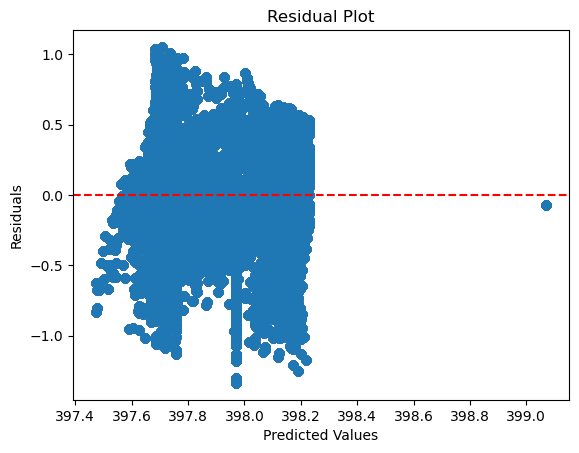

In [44]:
plt.scatter(Pre, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0 for reference
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [58]:
ana = pd.DataFrame({
    'node':node_df['Node_indicator'],
    'predictions': predictions[0],
    'residuals': residuals[0]
})
ana.head()

,node,predictions,residuals
0,1.0,0.347379,-0.053019
1,2.0,-0.376519,-0.053019
2,3.0,-0.292917,-0.053019
3,4.0,-0.465757,-0.053019
4,5.0,0.073012,-0.053019


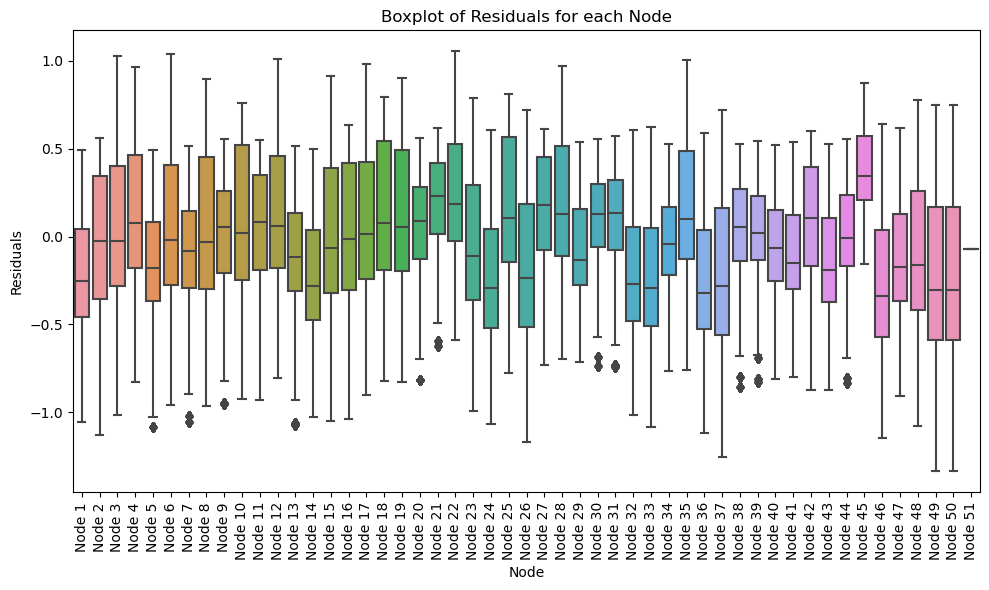

In [76]:
residuals_array =  np.array(residuals).reshape((-1, 51))
reshaped_ana = pd.DataFrame(residuals_array, columns=['Node ' + str(i+1) for i in range(51)])

plt.figure(figsize=(10, 6))  
sns.boxplot(data=reshaped_ana)
plt.xlabel('Node')
plt.ylabel('Residuals')
plt.title('Boxplot of Residuals for each Node')

plt.xticks(rotation=90)

plt.xticks(range(len(reshaped_ana.columns)), reshaped_ana.columns, rotation=90)

plt.tight_layout() 
plt.show()

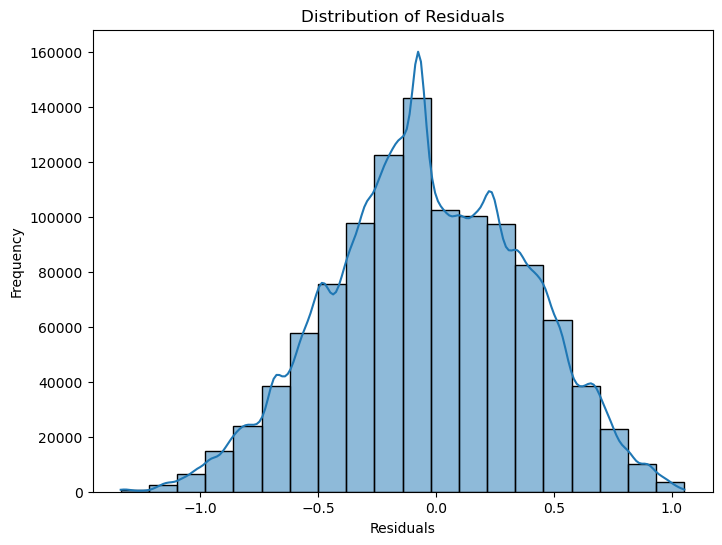

In [77]:
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
sns.histplot(residuals, kde=True, bins=20)  # kde=True adds a Kernel Density Estimation curve
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

In [94]:
Pre_array =  np.array(Pre).reshape((-1, 51,128))
Pre_array = np.mean(Pre_array, axis=2)
Pre_ana = pd.DataFrame(Pre_array, columns=['Node ' + str(i+1) for i in range(51)])
Pre_ana['Node 5']

0      397.833422
1      397.847938
2      397.952395
3      397.880316
4      397.821013
          ...    
164    397.830195
165    398.009641
166    397.856372
167    397.825986
168    398.048315
Name: Node 5, Length: 169, dtype: float64


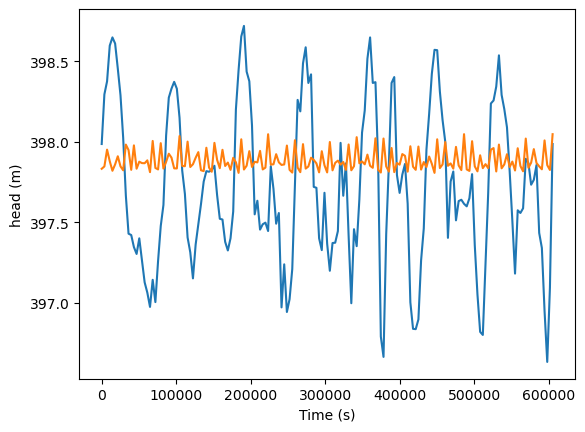

In [98]:
ax = head_at_node5.plot()
ax.set_xlabel("Time (s)")
ax.set_ylabel("head (m)")

Pre_ana = Pre_ana.set_index(head.index)

Pre_ana['Node 5'].plot(ax=ax)

plt.show()